## Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import datetime

np.random.seed(1337)  # for reproducibility
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error

from dbn.tensorflow import SupervisedDBNRegression

## Define Model Settings

In [2]:
RBM_EPOCHS = 5
DBN_EPOCHS = 150
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [20, 50, 100]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

## Define Directory, Road, and Year

In [3]:
# Read the dataset
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"
DATASET_DIVISION = "seasonWet"
DIR = "../../../datasets/Thesis Datasets/"

'''''''Training dataset'''''''
WP = False
weatherDT = "recon_weather" #orig_weather   recon_weather
featureEngineering = "" #Rolling   Expanding   Rolling and Expanding 
featuresNeeded = ['tempC', 'windspeedMiles', 'precipMM', 'visibility', #All Features
                'humidity', 'pressure', 'cloudcover', 'heatIndexC',
                'dewPointC', 'windChillC', 'windGustMiles', 'feelsLikeC']
# featuresNeeded = ['tempC', 'windspeedMiles', 'humidity', 'heatIndexC', #All corr > 0.1
#                 'dewPointC','windChillC', 'feelsLikeC']
# featuresNeeded = ['heatIndexC', 'windspeedMiles', 'dewPointC']
ROLLING_WINDOW = 3
EXPANDING_WINDOW = 12
RECON_SHIFT = 96

In [4]:
RBM_EPOCHS = 5
DBN_EPOCHS = 150
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [20, 50, 100]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

In [5]:
def reconstructDT(df, typeDataset='traffic', trafficFeatureNeeded=[]):
    result_df = df.copy()

    # Converting the index as date
    result_df.index = pd.to_datetime(result_df.index, format='%d/%m/%Y %H:%M')
#     result_df['year'] = result_df.index.year
    result_df['month'] = result_df.index.month
#     result_df['day'] = result_df.index.day
    result_df['hour'] = result_df.index.hour
    result_df['min'] = result_df.index.minute    
    result_df['dayOfWeek'] = result_df.index.dayofweek
    
    if typeDataset == 'traffic':
        for f in trafficFeatureNeeded:
            result_df[f + '_' + str(RECON_SHIFT)] = result_df[f].shift(RECON_SHIFT)    
            result_df[f + '_' + str(RECON_SHIFT)] = result_df[f].shift(RECON_SHIFT)
            
    result_df = result_df.iloc[96:, :]
    
    for f in range(len(result_df.columns)):
        result_df[result_df.columns[f]] = normalize(result_df[result_df.columns[f]])

    return result_df

def shiftDTForReconstructed(df):
    return df.iloc[shift:, :]

In [6]:
def getNeededFeatures(columns, arrFeaturesNeed=[], featureEngineering="Original"):
    to_remove = []
    if len(arrFeaturesNeed) == 0: #all features aren't needed
        return []
    else:
        if featureEngineering == "Original":
            compareTo = " "
        elif featureEngineering == "Rolling" or featureEngineering == "Expanding":
            compareTo = "_"
            
        for f in arrFeaturesNeed:
            for c in range(0, len(columns)):
                if (len(columns[c].split(compareTo)) <= 1 and featureEngineering != "Original"):
                    to_remove.append(c)
                if f not in columns[c].split(compareTo)[0] and columns[c].split(compareTo)[0] not in arrFeaturesNeed:
                    to_remove.append(c)
                        
    return to_remove

In [7]:
def normalize(data):
    y = pd.to_numeric(data)
    y = np.array(y.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y)
    y = y.reshape(1, -1)[0]
    return y

<br><br>
### Preparing Traffic Dataset

#### Importing Original Traffic (wo new features)

In [8]:
TRAFFIC_WINDOWSIZE = 3
TRAFFIC_DIR = DIR + "mmda/"
TRAFFIC_FILENAME = "mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
orig_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
orig_traffic = orig_traffic.fillna(0)

#Converting index to date and time, and removing 'dt' column
orig_traffic.index = pd.to_datetime(orig_traffic.dt, format='%d/%m/%Y %H:%M')
cols_to_remove = [0]
cols_to_remove = getNeededFeatures(orig_traffic.columns, ["statusN"])
orig_traffic.drop(orig_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
orig_traffic.head()

,statusN
dt,
2015-06-01 00:00:00,0.908264
2015-06-01 00:15:00,0.909505
2015-06-01 00:30:00,0.910818
2015-06-01 00:45:00,0.912204
2015-06-01 01:00:00,0.913664


#### Importing Original Weather (wo new features)

In [9]:
WEATHER_DIR = DIR + "wwo/"
WEATHER_FILENAME = "wwo_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION

orig_weather = pd.read_csv(WEATHER_DIR + WEATHER_FILENAME + EXT, skipinitialspace=True)

cols_to_remove = [0]
cols_to_remove += getNeededFeatures(orig_weather.columns, arrFeaturesNeed=featuresNeeded)

orig_weather.index = pd.to_datetime(orig_weather.dt, format='%d/%m/%Y %H:%M')
orig_weather.drop(orig_weather.columns[[cols_to_remove]], axis=1, inplace=True)
orig_weather.head()

,tempC,windspeedMiles,precipMM,humidity,visibility,pressure,cloudcover,heatIndexC,dewPointC,windChillC,windGustMiles,feelsLikeC
dt,,,,,,,,,,,,
2015-06-01 00:00:00,0.294118,0.107143,0.0,0.629630,1.0,0.769231,0.7400,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 00:15:00,0.294118,0.116071,0.0,0.634259,1.0,0.769231,0.7175,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 00:30:00,0.294118,0.125000,0.0,0.638889,1.0,0.769231,0.6950,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 00:45:00,0.294118,0.133929,0.0,0.643519,1.0,0.769231,0.6725,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 01:00:00,0.294118,0.142857,0.0,0.648148,1.0,0.769231,0.6500,0.26087,0.5,0.294118,0.090909,0.26087


#### Importing Weather with Rolling features (with only needed features)

In [10]:
WEATHER_DIR = DIR + "wwo/Rolling/" + DATASET_DIVISION + "/"
WEATHER_FILENAME = "eng_win" + str(ROLLING_WINDOW) + "_wwo_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
rolling_weather = pd.read_csv(WEATHER_DIR + WEATHER_FILENAME + EXT, skipinitialspace=True)

cols_to_remove = []
cols_to_remove += getNeededFeatures(rolling_weather.columns, orig_weather.columns, featureEngineering="Rolling")
rolling_weather.index = pd.to_datetime(rolling_weather.dt, format='%Y-%m-%d %H:%M')

rolling_weather.drop(rolling_weather.columns[[cols_to_remove]], axis=1, inplace=True)

for f in range(len(rolling_weather.columns)):
        rolling_weather[rolling_weather.columns[f]] = normalize(rolling_weather[rolling_weather.columns[f]])

rolling_weather.head() 

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,tempC_Rmean=3,windspeedMiles_Rmean=3,precipMM_Rmean=3,humidity_Rmean=3,visibility_Rmean=3,pressure_Rmean=3,cloudcover_Rmean=3,heatIndexC_Rmean=3,dewPointC_Rmean=3,windChillC_Rmean=3,...,precipMM_Rmax=3,humidity_Rmax=3,visibility_Rmax=3,pressure_Rmax=3,cloudcover_Rmax=3,heatIndexC_Rmax=3,dewPointC_Rmax=3,windChillC_Rmax=3,windGustMiles_Rmax=3,feelsLikeC_Rmax=3
dt,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.00000,0.0,0.000000,0.000000,0.00000
2015-06-01 00:15:00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00,0.00000,0.0,0.000000,0.000000,0.00000
2015-06-01 00:30:00,0.099502,0.035714,0.0,0.210853,0.333333,0.258065,0.246667,0.087591,0.166667,0.099502,...,0.0,0.629630,1.0,0.769231,0.74,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 00:45:00,0.199005,0.074405,0.0,0.423256,0.666667,0.516129,0.485833,0.175182,0.333333,0.199005,...,0.0,0.634259,1.0,0.769231,0.74,0.26087,0.5,0.294118,0.090909,0.26087
2015-06-01 01:00:00,0.298507,0.116071,0.0,0.637209,1.000000,0.774194,0.717500,0.262774,0.500000,0.298507,...,0.0,0.638889,1.0,0.769231,0.74,0.26087,0.5,0.294118,0.090909,0.26087


#### Importing Weather with Expanding features (with only needed features)

In [11]:
WEATHER_DIR = DIR + "wwo/Expanding/" + DATASET_DIVISION + "/"
WEATHER_FILENAME = "eng_win" + str(EXPANDING_WINDOW) + "_wwo_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
expanding_weather = pd.read_csv(WEATHER_DIR + WEATHER_FILENAME + EXT, skipinitialspace=True)

cols_to_remove = []
cols_to_remove += getNeededFeatures(expanding_weather.columns, orig_weather.columns, featureEngineering="Rolling")
     
expanding_weather.index = pd.to_datetime(expanding_weather.dt, format='%d/%m/%Y %H:%M')

expanding_weather.drop(expanding_weather.columns[[cols_to_remove]], axis=1, inplace=True)

for f in range(len(expanding_weather.columns)):
        expanding_weather[expanding_weather.columns[f]] = normalize(expanding_weather[expanding_weather.columns[f]])

expanding_weather.head()

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,tempC_Emin=12,tempC_Emax=12,tempC_Esum=12,tempC_Emean=12,windspeedMiles_Emin=12,windspeedMiles_Emax=12,windspeedMiles_Esum=12,windspeedMiles_Emean=12,precipMM_Emin=12,precipMM_Emax=12,...,heatIndexC_Esum=12,heatIndexC_Emean=12,dewPointC_Emin=12,dewPointC_Emax=12,dewPointC_Esum=12,dewPointC_Emean=12,windChillC_Emin=12,windChillC_Emax=12,windChillC_Esum=12,windChillC_Emean=12
dt,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,0.294118,0.294118,0.025907,0.294118,0.107143,0.107143,0.008929,0.107143,0.0,0.0,...,0.022989,0.26087,0.5,0.5,0.041667,0.5,0.294118,0.294118,0.025907,0.294118
2015-06-01 00:15:00,0.294118,0.294118,0.051813,0.294118,0.107143,0.116071,0.018601,0.111607,0.0,0.0,...,0.045977,0.26087,0.5,0.5,0.083333,0.5,0.294118,0.294118,0.051813,0.294118
2015-06-01 00:30:00,0.294118,0.294118,0.077720,0.294118,0.107143,0.125000,0.029018,0.116071,0.0,0.0,...,0.068966,0.26087,0.5,0.5,0.125000,0.5,0.294118,0.294118,0.077720,0.294118
2015-06-01 00:45:00,0.294118,0.294118,0.103627,0.294118,0.107143,0.133929,0.040179,0.120536,0.0,0.0,...,0.091954,0.26087,0.5,0.5,0.166667,0.5,0.294118,0.294118,0.103627,0.294118
2015-06-01 01:00:00,0.294118,0.294118,0.129534,0.294118,0.107143,0.142857,0.052083,0.125000,0.0,0.0,...,0.114943,0.26087,0.5,0.5,0.208333,0.5,0.294118,0.294118,0.129534,0.294118


#### Reconstructing Weather Input for recon_weather dataset

In [12]:
recon_weather = reconstructDT(orig_weather, 'weather', ['statusN'])
recon_weather.head()

c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ronnie nieva\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,tempC,windspeedMiles,precipMM,humidity,visibility,pressure,cloudcover,heatIndexC,dewPointC,windChillC,windGustMiles,feelsLikeC,month,hour,min,dayOfWeek
dt,,,,,,,,,,,,,,,,
2015-06-02 00:00:00,0.294118,0.178571,0.0,0.722222,1.0,0.807692,0.08,0.304348,0.625,0.294118,0.113636,0.304348,0.0,0.000000,0.000000,0.166667
2015-06-02 00:15:00,0.294118,0.178571,0.0,0.726852,1.0,0.807692,0.08,0.293478,0.625,0.294118,0.113636,0.293478,0.0,0.000000,0.333333,0.166667
2015-06-02 00:30:00,0.294118,0.178571,0.0,0.731481,1.0,0.807692,0.08,0.282609,0.625,0.294118,0.113636,0.282609,0.0,0.000000,0.666667,0.166667
2015-06-02 00:45:00,0.294118,0.178571,0.0,0.736111,1.0,0.807692,0.08,0.271739,0.625,0.294118,0.113636,0.271739,0.0,0.000000,1.000000,0.166667
2015-06-02 01:00:00,0.294118,0.178571,0.0,0.740741,1.0,0.807692,0.08,0.260870,0.625,0.294118,0.113636,0.260870,0.0,0.043478,0.000000,0.166667


### Merging datasets

In [13]:
''''''' Do not touch below '''''''

if weatherDT == "orig_weather":
    print("Adding orig_weather")
    arrDT = [orig_traffic, orig_weather]
    
elif weatherDT == "recon_weather":
    print("Adding recon_weather")
    arrDT = [orig_traffic.iloc[96:, :], recon_weather]
    
if featureEngineering == "Rolling":
    print("Adding Rolling")
    startIndex = np.absolute(len(arrDT[0])-len(rolling_weather))
    temp = rolling_weather.iloc[startIndex:, :]
    arrDT.append(temp)
    
elif featureEngineering == "Expanding":
    print("Adding Expanding")
    startIndex = np.absolute(len(arrDT[0])-len(expanding_weather))
    temp = expanding_weather.iloc[startIndex:, :]
    arrDT.append(temp)
    
elif featureEngineering == "Rolling and Expanding":
    print("Adding Rolling and Expanding")
    #Rolling
    startIndex = np.absolute(len(arrDT[0])-len(rolling_weather))
    temp = rolling_weather.iloc[startIndex:, :]
    arrDT.append(temp)
    #Expanding
    startIndex = np.absolute(len(arrDT[0])-len(expanding_weather))
    temp = expanding_weather.iloc[startIndex:, :]
    arrDT.append(temp)

merged_dataset = pd.concat(arrDT, axis=1)
merged_dataset.head()

Adding recon_weather


,statusN,tempC,windspeedMiles,precipMM,humidity,visibility,pressure,cloudcover,heatIndexC,dewPointC,windChillC,windGustMiles,feelsLikeC,month,hour,min,dayOfWeek
dt,,,,,,,,,,,,,,,,,
2015-06-02 00:00:00,0.438567,0.294118,0.178571,0.0,0.722222,1.0,0.807692,0.08,0.304348,0.625,0.294118,0.113636,0.304348,0.0,0.000000,0.000000,0.166667
2015-06-02 00:15:00,0.555569,0.294118,0.178571,0.0,0.726852,1.0,0.807692,0.08,0.293478,0.625,0.294118,0.113636,0.293478,0.0,0.000000,0.333333,0.166667
2015-06-02 00:30:00,0.683338,0.294118,0.178571,0.0,0.731481,1.0,0.807692,0.08,0.282609,0.625,0.294118,0.113636,0.282609,0.0,0.000000,0.666667,0.166667
2015-06-02 00:45:00,0.795359,0.294118,0.178571,0.0,0.736111,1.0,0.807692,0.08,0.271739,0.625,0.294118,0.113636,0.271739,0.0,0.000000,1.000000,0.166667
2015-06-02 01:00:00,0.874074,0.294118,0.178571,0.0,0.740741,1.0,0.807692,0.08,0.260870,0.625,0.294118,0.113636,0.260870,0.0,0.043478,0.000000,0.166667


## Preparing Training dataset

### Merge Original (and Rolling and Expanding)

In [14]:
# To-be Predicted variable 
Y = merged_dataset.statusN
Y = Y.fillna(0)

In [15]:
# Training Data
X = merged_dataset
X = X.drop(X.columns[[0]], axis=1)

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.67, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Data scaling
# min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)

#Print training and testing data
pd.concat([X, Y.to_frame()], axis=1).head()

,tempC,windspeedMiles,precipMM,humidity,visibility,pressure,cloudcover,heatIndexC,dewPointC,windChillC,windGustMiles,feelsLikeC,month,hour,min,dayOfWeek,statusN
dt,,,,,,,,,,,,,,,,,
2015-06-02 00:00:00,0.294118,0.178571,0.0,0.722222,1.0,0.807692,0.08,0.304348,0.625,0.294118,0.113636,0.304348,0.0,0.000000,0.000000,0.166667,0.438567
2015-06-02 00:15:00,0.294118,0.178571,0.0,0.726852,1.0,0.807692,0.08,0.293478,0.625,0.294118,0.113636,0.293478,0.0,0.000000,0.333333,0.166667,0.555569
2015-06-02 00:30:00,0.294118,0.178571,0.0,0.731481,1.0,0.807692,0.08,0.282609,0.625,0.294118,0.113636,0.282609,0.0,0.000000,0.666667,0.166667,0.683338
2015-06-02 00:45:00,0.294118,0.178571,0.0,0.736111,1.0,0.807692,0.08,0.271739,0.625,0.294118,0.113636,0.271739,0.0,0.000000,1.000000,0.166667,0.795359
2015-06-02 01:00:00,0.294118,0.178571,0.0,0.740741,1.0,0.807692,0.08,0.260870,0.625,0.294118,0.113636,0.260870,0.0,0.043478,0.000000,0.166667,0.874074


In [16]:
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=HIDDEN_LAYER_STRUCT,
                                    learning_rate_rbm=RBM_LEARNING_RATE,
                                    learning_rate=DBN_LEARNING_RATE,
                                    n_epochs_rbm=RBM_EPOCHS,
                                    n_iter_backprop=DBN_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    activation_function=ACTIVE_FUNC)
regressor.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.738304
>> Epoch 2 finished 	RBM Reconstruction error 0.719514
>> Epoch 3 finished 	RBM Reconstruction error 0.686181
>> Epoch 4 finished 	RBM Reconstruction error 0.628741
>> Epoch 5 finished 	RBM Reconstruction error 0.549223
>> Epoch 1 finished 	RBM Reconstruction error 0.120895
>> Epoch 2 finished 	RBM Reconstruction error 0.120219
>> Epoch 3 finished 	RBM Reconstruction error 0.119826
>> Epoch 4 finished 	RBM Reconstruction error 0.116604
>> Epoch 5 finished 	RBM Reconstruction error 0.113028
>> Epoch 1 finished 	RBM Reconstruction error 0.014515
>> Epoch 2 finished 	RBM Reconstruction error 0.012215
>> Epoch 3 finished 	RBM Reconstruction error 0.012186
>> Epoch 4 finished 	RBM Reconstruction error 0.012121
>> Epoch 5 finished 	RBM Reconstruction error 0.012207
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss 0.079159
>> Epoch 1 finished 	ANN training loss 0.078911
>>

>> Epoch 149 finished 	ANN training loss 0.051103
[END] Fine tuning step


SupervisedDBNRegression(batch_size=28, dropout_p=0, l2_regularization=1.0,
            learning_rate=0.01, n_iter_backprop=150, verbose=True)

In [17]:
#To check RBM Loss Errors:
rbm_error = regressor.unsupervised_dbn.rbm_layers[0].rbm_loss_error
#To check DBN Loss Errors
dbn_error = regressor.dbn_loss_error

In [18]:
# Test
# X_test = min_max_scaler.transform(X_test)
# Y_pred = regressor.predict(X_test)

min_max_scaler = MinMaxScaler()
X_test = min_max_scaler.fit_transform(X_test)
Y_pred = regressor.predict(X_test)

r2score = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
print('Done.\nR-squared: %.3f\nRMSE: %.3f \nMAE: %.3f' % (r2score, rmse, mae))

Done.
R-squared: 0.295
RMSE: 0.268 
MAE: 0.222


In [19]:
# Save the model
regressor.save('models/pm2_' + ROAD + '_' + YEAR + '.pkl')

### Results and Analysis below

##### Printing Predicted and Actual Results

In [20]:
startIndex = orig_weather.shape[0] - Y_pred.shape[0]
dt = orig_weather.index[startIndex:,]
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test, 'dt':dt}

df = pd.DataFrame(data=d)
df.head()

,Actual,Predicted,dt
0,0.932784,0.837742,2015-07-22 03:45:00
1,0.940946,0.798834,2015-07-22 04:00:00
2,0.937501,0.802532,2015-07-22 04:15:00
3,0.916327,0.806225,2015-07-22 04:30:00
4,0.870975,0.809881,2015-07-22 04:45:00


In [21]:
df.tail()

,Actual,Predicted,dt
9772,0.307593,0.560165,2015-10-31 22:45:00
9773,0.289160,0.558413,2015-10-31 23:00:00
9774,0.284117,0.548637,2015-10-31 23:15:00
9775,0.304501,0.538862,2015-10-31 23:30:00
9776,0.360046,0.530390,2015-10-31 23:45:00


In [22]:
df.to_csv("output/pm2_" + ROAD + "_" + YEAR + EXT, encoding='utf-8')

#### Visualize trend of loss of RBM and DBN Training

In [23]:
import matplotlib.pyplot as plt

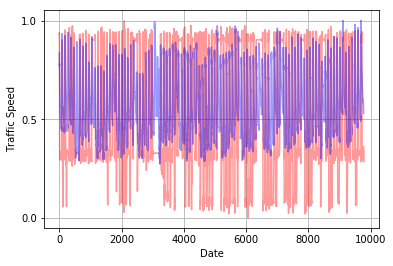

In [24]:
line1 = df.Actual
line2 = df.Predicted

plt.grid()
plt.plot(line1, c='red', alpha=0.4)
plt.plot(line2, c='blue', alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Traffic Speed")
plt.yticks([0, 0.5, 1.0])
plt.show()

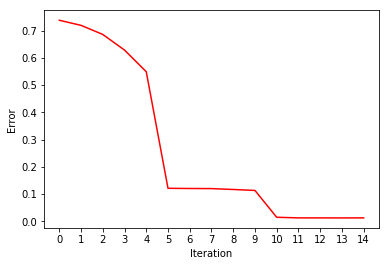

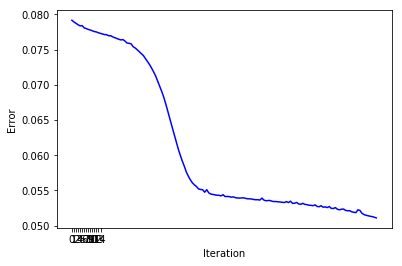

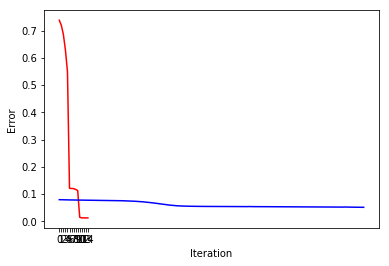

In [25]:
line1 = rbm_error
line2 = dbn_error
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()